In [115]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [116]:
import csv
import numpy

import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt

In [213]:
players_df = pd.read_csv('playerDB.csv')
draft_df = pd.read_csv('draftDB.csv')

# load externel link dataset
link_df = pd.read_csv('NBA_Player_IDs.csv',  encoding= 'unicode_escape')
link_df = link_df[pd.notna(link_df['NBAID'])]
link_df.loc[:,'NBAID'] = link_df.loc[:,'NBAID'].astype(int)

# Only consider first 2 rounds
draft_df = draft_df[draft_df['numberRound']<=2]
# Limit to the 3-pt era
draft_df = draft_df[draft_df['yearDraft']>=1979]
# Only consider players with 4 years of data
draft_df = draft_df[draft_df['yearDraft']<=2015]
num_drafts = len(draft_df.yearDraft.unique())

# Get year from season string
players_df.loc[:,'year'] = players_df['Season'].apply(lambda season: int(season.split('-')[0]))

curr_miss = draft_df[draft_df.basketball_reference_url.isna()]
print(f'Missing {len(curr_miss)} links between player and draft')

# Merge draft and link dataframe
draft_df = draft_df.merge(link_df, how='left', left_on='idPlayer', right_on='NBAID')
draft_df.loc[:,'urlID'] = draft_df.loc[:,'BBRefID'] 

curr_miss = draft_df[draft_df.urlID.isna()]
print(f'Missing {len(curr_miss)} links between player and draft')

# Add combine player and draft
combined_df = players_df.merge(draft_df, how='inner', on='urlID')

num_players_yrs = len(combined_df)
num_players = len(combined_df.urlID.unique())

print(f'{num_players} distinct players with {num_players_yrs} player-seasons of data')

# Limit to 4 seasons
only_4_years = combined_df[(combined_df['year']-combined_df['yearDraft'])<=3]

# Calculate total winshares per player
avg_rookie_ws = only_4_years.groupby('numberPickOverall')['WS'].sum()/num_drafts
avg_rookie_ws.to_csv('avg_rookie_winshare.csv')

Missing 684 links between player and draft
Missing 297 links between player and draft
1731 distinct players with 12087 player-seasons of data


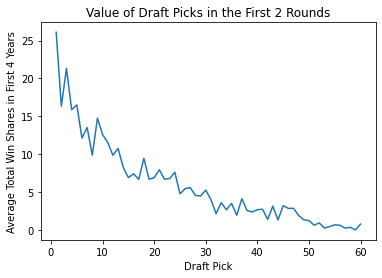

In [214]:
plt.plot(avg_rookie_ws.index, avg_rookie_ws.values)
plt.title('Value of Draft Picks in the First 2 Rounds')
plt.ylabel('Average Total Win Shares in First 4 Years')
plt.xlabel('Draft Pick')
plt.savefig('figure1.png')

In [198]:
trade_val = pd.Series(index=avg_rookie_ws.index, data=avg_rookie_ws.sort_values(ascending=False).values)

In [199]:
def trade_eval(give_picks, receive_picks):
    give_val = trade_val.loc[give_picks].sum()
    receive_val = trade_val.loc[receive_picks].sum()
    
    success = receive_val > give_val
    if success:
        print("\nTrade result: Success! This trade receives more value than it gives away.\n")
        # Print additional metrics/reasoning here
    else:
        print("\nTrade result: Don't do it! This trade gives away more value than it receives.\n")
        # Print additional metrics/reasoning here
        
    print(f'Give val: {give_val}')
    print(f'Receive val: {receive_val}')
    

In [200]:
trade_eval([3],[2])


Trade result: Success! This trade receives more value than it gives away.

Give val: 16.5
Receive val: 21.324324324324323


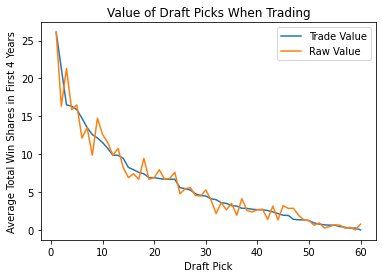

In [201]:
plt.plot(trade_val.index, trade_val.values, label='Trade Value')
plt.plot(avg_rookie_ws.index, avg_rookie_ws.values, label='Raw Value')
plt.title('Value of Draft Picks When Trading')
plt.ylabel('Average Total Win Shares in First 4 Years')
plt.legend()
plt.xlabel('Draft Pick')
plt.savefig('figure2.png')

In [202]:
salary_df = pd.read_csv('salaries_1985to2018.csv')

In [203]:
after_1985 = combined_df[combined_df['year']>=1985]
merged_salary_df = salary_df.merge(after_1985, how='right', left_on=['player_id', 'season'], right_on=['urlID', 'Season'])
missing_rows =merged_salary_df[merged_salary_df.salary.isna()]
print(f'Only missing {len(missing_rows)} rows of salary data from {len(missing_rows.Player.unique())} players')
merged_salary_df =merged_salary_df[~merged_salary_df.salary.isna()]
just_fifth_season  = merged_salary_df[(merged_salary_df['year']-merged_salary_df['yearDraft'])==4]
just_fifth_season.loc[:,'salary_rank'] = just_fifth_season.groupby('year').rank(ascending=True)['salary']
yearly_max_ranks  = just_fifth_season.groupby('year').max()['salary_rank'].rename('yearly_max_rank')
just_fifth_season = just_fifth_season.merge(yearly_max_ranks, right_index=True, left_on=['year'])

just_fifth_season.loc[:,'salary_rank_normalized'] = just_fifth_season['salary_rank']/just_fifth_season['yearly_max_rank']

avg_5th_year_salary = just_fifth_season.groupby('numberPickOverall')['salary_rank_normalized'].sum()
avg_5th_year_salary_norm  =avg_5th_year_salary/avg_5th_year_salary.max()

avg_rookie_ws_norm = avg_rookie_ws/avg_rookie_ws.max()

Only missing 1061 rows of salary data from 782 players


/home/kheuton/anaconda3/envs/opioid/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/kheuton/anaconda3/envs/opioid/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  


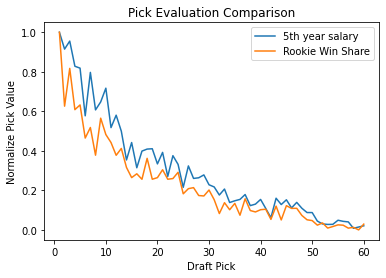

In [204]:
plt.plot(avg_5th_year_salary_norm.index, avg_5th_year_salary_norm.values, label='5th year salary')
plt.plot(avg_rookie_ws_norm.index, avg_rookie_ws_norm.values, label='Rookie Win Share')
plt.legend()
plt.title('Pick Evaluation Comparison')
plt.ylabel('Normalize Pick Value')
plt.xlabel('Draft Pick')
plt.savefig('figure3.png')

In [206]:
num_drafts

37

In [210]:
my_df = pd.read_csv('avg_rookie_winshare.csv', index_col=0)

In [212]:
my_df.WS

numberPickOverall
1     26.100000
2     16.335135
3     21.324324
4     15.875676
5     16.500000
6     12.124324
7     13.516216
8      9.859459
9     14.748649
10    12.586486
11    11.532432
12     9.845946
13    10.748649
14     8.243243
15     6.897297
16     7.402703
17     6.678378
18     9.443243
19     6.683784
20     6.894595
21     7.935135
22     6.683784
23     6.772973
24     7.600000
25     4.759459
26     5.437838
27     5.572973
28     4.532432
29     4.472973
30     5.259459
31     3.983784
32     2.151351
33     3.586486
34     2.654054
35     3.491892
36     1.929730
37     4.105405
38     2.548649
39     2.362162
40     2.659459
41     2.721622
42     1.381081
43     3.132432
44     1.308108
45     3.191892
46     2.829730
47     2.845946
48     1.900000
49     1.327027
50     1.221622
51     0.618919
52     0.910811
53     0.232432
54     0.435135
55     0.656757
56     0.613514
57     0.224324
58     0.329730
59    -0.010811
60     0.754054
Name: WS, dtype: float